In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Image manipulation (map-making)
def rotate_image(image, 
                 angle, 
                 center=None, 
                 scale=1.0):
    (h, w) = image.shape[:2]

    # Default center: image center
    if center is None:
        center = (w / 2, h / 2)

    # Compute rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # Get coordinates of original image corners
    corners = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ], dtype=np.float32).reshape(-1, 1, 2)

    # Transform corners with rotation matrix
    rotated_corners = cv2.transform(corners, M)

    # Find new bounding box
    [xmin, ymin] = np.int32(rotated_corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(rotated_corners.max(axis=0).ravel())
    new_w = xmax - xmin
    new_h = ymax - ymin

    # Compute translation to shift image so it's fully in view
    tx = -xmin
    ty = -ymin

    # Add translation to rotation matrix
    M[0, 2] += tx
    M[1, 2] += ty

    # Warp the image
    rotated = cv2.warpAffine(image, M, (new_w, new_h))
    return rotated


In [7]:
jetson = 0
if jetson:
    def show_image(image, axis=True, show=False):
        cv2.imshow("image", image)
else:
    def show_image(image, axis=True, show=False):
        # cv2.imshow doesn't work on Mac
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not axis:
            plt.axis("off")
        if show:
            plt.show()
            

In [9]:
def crop_image(image, top=0, left=0, bottom=None, right=None):
    if bottom:
        if right:
            return image[top:-bottom, left:-right]
        else:
            return image[top:-bottom, left:]
    else:
        if right:
            return image[top:, left:-right]
        else:
            return image[top:, left:]



In [11]:
def make_vector(p1, p2):
    p1_coords = np.array(p1[0:2])
    p2_coords = np.array(p2[0:2])
    return p2_coords - p1_coords

def distance(p1, p2):
    return np.linalg.norm(make_vector(p1, p2))

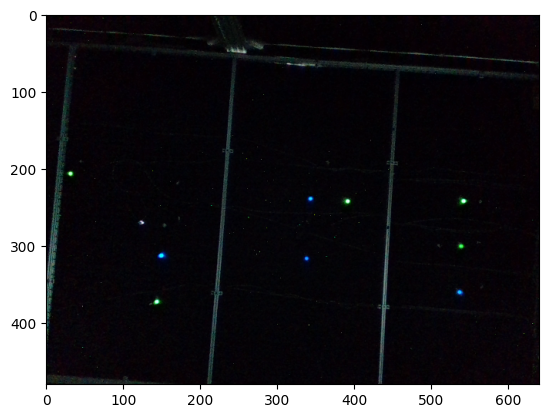

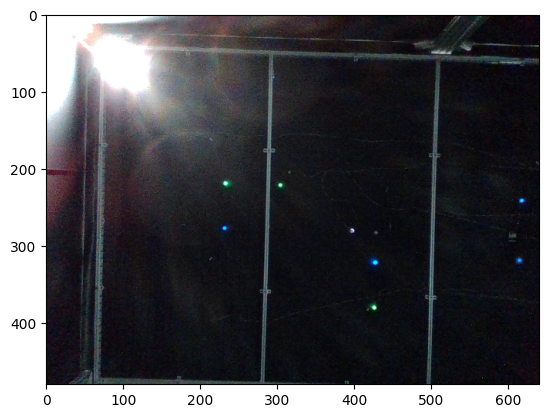

In [10]:
img1 = cv2.imread("jun_12_frame_9.png")
img2 = cv2.imread("jun_12_frame_14.png")

show_image(img1, show=True)
show_image(img2, show=True)

In [12]:
## Processing
def find_centroids(img, visualize=False, vis_masks=False, area_threshold=10, dist_threshold=5, blue_threshold=120):
    # HSV ranges for green and blue
    lower_green = np.array([40, 100, 40])
    upper_green = np.array([80, 255, 255])

    lower_blue = np.array([100, 100, 40])
    upper_blue = np.array([140, 255, 255])

    # convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    # Extract blue channel
    blue = img[:, :, 0]
    _, blue_blue_mask = cv2.threshold(blue, blue_threshold, 255, cv2.THRESH_BINARY)

    # combine blue masks for the ULTIMATE BLUE
    blue_mask = cv2.bitwise_and(blue_mask, blue_blue_mask)

    if vis_masks:
        plt.imshow(green_mask, cmap='Greys')
        plt.title(f"Green")
        plt.show()
        plt.imshow(blue_mask, cmap='Greys')
        plt.title(f"Blue")
        plt.show()
    led_centroids = []
    i = 0
    for mask in [green_mask, blue_mask]:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Get LED centroids
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > area_threshold:  # Area threshold
                M = cv2.moments(cnt)
                if M["m00"] > 0:
                    cx = M["m10"] / M["m00"]
                    cy = M["m01"] / M["m00"]
                    new_centroid = (cx, cy)
                    check_dist = [distance(new_centroid, c) for c in led_centroids]
                    if len(check_dist) > 0:
                        if min(check_dist) > dist_threshold:  # Distance threshold
                            led_centroids.append((cx, cy, i))
                    else:
                        led_centroids.append((cx, cy, i))
                    # led_centroids.append((cx, cy, i))
        i += 1
    led_centroids = np.array(led_centroids)
    if visualize:
        output = img.copy()
        for point in led_centroids:
            x, y, c = point
            x, y = int(np.round(x)), int(np.round(y))
            if c == 1:
                text = 'B'
            else:
                text = 'G'
            cv2.putText(output, f'{text}({x},{y})', (x - 40, y - 5), fontFace=cv2.FONT_HERSHEY_DUPLEX,
                        fontScale=.75, color=(0, 0, 255), thickness=1)
        show_image(output)
        plt.show()
    return led_centroids

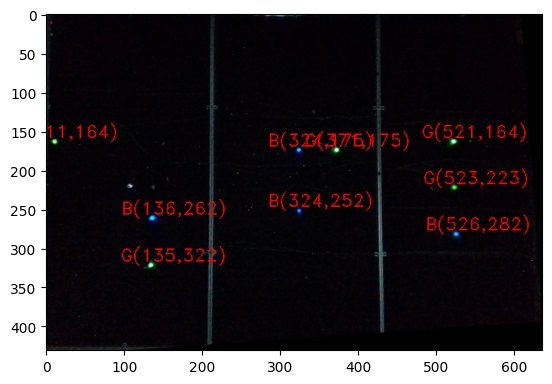

[[134.62872629 321.9403794    0.        ]
 [523.0651341  222.62835249   0.        ]
 [371.26995305 175.23004695   0.        ]
 [521.31746032 164.10204082   0.        ]
 [ 10.61648746 164.07168459   0.        ]
 [525.86419753 282.37654321   1.        ]
 [136.0962963  261.65925926   1.        ]
 [324.36752137 252.36752137   1.        ]
 [323.89583333 174.65277778   1.        ]]
(431, 636, 3)


In [13]:
rotated1=rotate_image(img1, 4, center=(0, 0))
cropped1 = crop_image(rotated1, top=84, left=35, bottom=7)
#cropped1=rotated1[84:-7, 35:]
show_image(cropped1)
cens1 = find_centroids(cropped1, visualize=True, area_threshold=10, dist_threshold=5)
print(cens1)
print(cropped1.shape)

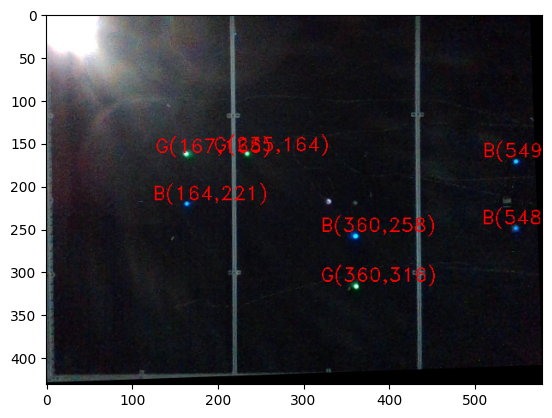

[[360.39166667 315.91875      0.        ]
 [235.36477987 163.93710692   0.        ]
 [167.15384615 166.23626374   0.        ]
 [360.26       257.81333333   1.        ]
 [548.32592593 249.25185185   1.        ]
 [164.05228758 220.67973856   1.        ]
 [548.55555556 171.47953216   1.        ]]
(431, 579, 3)


In [16]:
rotated2=rotate_image(img2, 2, center=(70, 30))
cropped2 = crop_image(rotated2, top=70, left=77)
#cropped2 = rotated2[70:,77:]
show_image(cropped2)
cens2 = find_centroids(cropped2, visualize=True, area_threshold=10, dist_threshold=5)
print(cens2)
print(cropped2.shape)

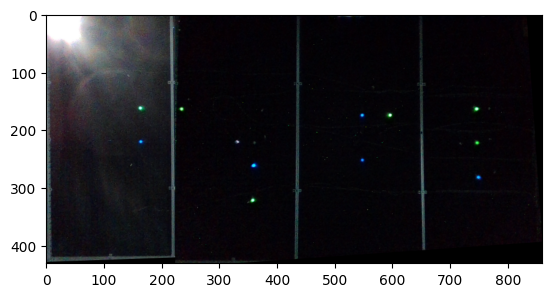

In [17]:
cropped3=cropped2[:, :224]
together = np.hstack([cropped3, cropped1])
show_image(together)
#show_image(cropped3)

In [ ]:
#cv2.imwrite('jun19_map.png', together) #When you are ready to save